<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap10/TrialV6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-_kfubor3
Albumentation library is successfully installed!


In [2]:
# mount gdrive and unzip data
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap10/'
os.chdir(folder)
print(os.getcwd()) 
for root, dirs, files in os.walk("."):
    for filename in files:
        print(filename)
sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap10
TrialV5.ipynb
bestmodel.pt
gradcam.py
load_data.py
model.py
show_images.py
__init__.py
transforms.py
lr_finder.py
evaluate.py
train_test.py
plot.py
__init__.cpython-36.pyc
load_data.cpython-36.pyc
show_images.cpython-36.pyc
model.cpython-36.pyc
train_test.cpython-36.pyc
evaluate.cpython-36.pyc
transforms.cpython-36.pyc
gradcam.cpython-36.pyc
lr_finder.cpython-36.pyc
plot.cpython-36.pyc
cifar-10-python.tar.gz
data_batch_4
readme.html
test_batch
data_batch_3
batches.meta
data_batch_2
data_batch_5
data_batch_1


In [0]:
%matplotlib inline
import torch
from template import load_data
from template import show_images
from template import model
from template import train_test
from template import evaluate
from template import transforms
from template import gradcam
from template import lr_finder
from template import plot

In [0]:
import albumentations as A
train_transform_list = [
                          A.Rotate((-30.0, 30.0)),
                          A.HorizontalFlip(),
                          A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                          A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                          A.Cutout(num_holes=2, max_h_size=9,max_w_size = 9,p=0.7) # fillvalue is 0 after normalizing as mean is 0
                       ]
test_transform_list = [A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
train_transform = transforms.AlbumentationTransforms(train_transform_list)
test_transform = transforms.AlbumentationTransforms(test_transform_list)

In [6]:
classes, trainloader, testloader = load_data.load(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


**Some Training Data**

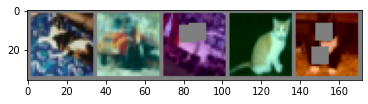

In [7]:
show_images.show_images(trainloader, classes)

**Print Model Summary**

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [9]:
pip install --no-cache-dir git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!"

  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-28v4bsxu
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!


**LR Finder - Finds the best possible LR**


In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0001)
lrfinder = lr_finder.LRFinder(model, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=100 ,step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


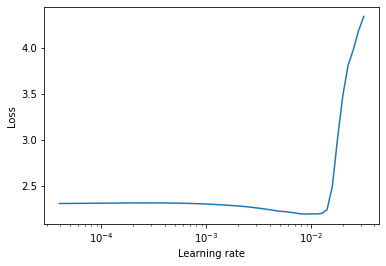

In [11]:
lrfinder.plot()

In [12]:
best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]
print(best_lr)

0.008912509381337452


In [0]:
lrfinder.reset()

**Initialise Loss funtion, Optimizer, Scheduler**

In [14]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR, ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9 ,weight_decay = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)
print(optimizer.param_groups[0]['lr'])

0.008912509381337452


**Train the Model for 50 Epochs**

In [15]:
test_loss = []
test_acc = []
train_loss = []
train_acc = []
EPOCHS = 10
best_acc = 0
for epoch in range(EPOCHS):
     print("\n EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_loss, train_acc = train_test.train(model, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     scheduler.step(test_loss[-1])
     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/school_of_ai/chap10/bestmodel.pt")

  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 1 LR: 0.008912509381337452


Loss=2.444214344024658 Batch_id=0 Accuracy=6.25:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0182, Accuracy: 1004/10000 (10.04%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 2 LR: 0.008912509381337452


Loss=2.2951724529266357 Batch_id=0 Accuracy=17.19:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 1002/10000 (10.02%)


 EPOCH: 3 LR: 0.008912509381337452


Loss=2.28002667427063 Batch_id=0 Accuracy=13.28:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 1000/10000 (10.00%)


 EPOCH: 4 LR: 0.008912509381337452


Loss=2.3189895153045654 Batch_id=0 Accuracy=10.16:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 1000/10000 (10.00%)


 EPOCH: 5 LR: 0.008912509381337452


Loss=2.3408327102661133 Batch_id=0 Accuracy=12.50:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 1000/10000 (10.00%)


 EPOCH: 6 LR: 0.0008912509381337453


Loss=2.3391363620758057 Batch_id=0 Accuracy=10.94:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 1000/10000 (10.00%)


 EPOCH: 7 LR: 0.0008912509381337453


Loss=2.30381178855896 Batch_id=0 Accuracy=14.84:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 1000/10000 (10.00%)


 EPOCH: 8 LR: 0.0008912509381337453


Loss=2.349241256713867 Batch_id=0 Accuracy=15.62:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 1000/10000 (10.00%)


 EPOCH: 9 LR: 0.0008912509381337453


Loss=2.348578453063965 Batch_id=0 Accuracy=9.38:   0%|          | 0/391 [00:00<?, ?it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 1000/10000 (10.00%)


 EPOCH: 10 LR: 0.0001


Loss=2.2757716178894043 Batch_id=0 Accuracy=10.16:   0%|          | 0/391 [00:00<?, ?it/s]



Test set: Average loss: 0.0185, Accuracy: 1000/10000 (10.00%)



**Load the Best Accuracy Model**


In [16]:
optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/school_of_ai/chap10/bestmodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


In [17]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 10 %


In [18]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck : 100 %


**Plot Loss Change in test**


Text(0.5, 1.0, 'Test Accuracy')

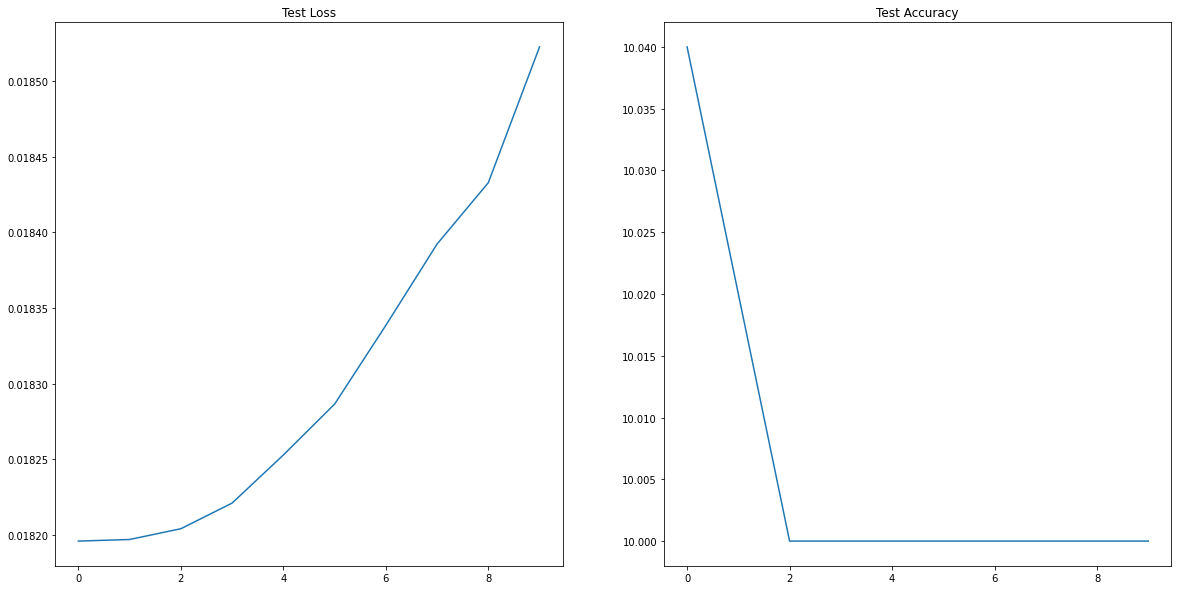

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(test_loss)
axs[0].set_title("Test Loss")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

**Plot Loss Change in train**


Text(0.5, 1.0, 'Train Accuracy')

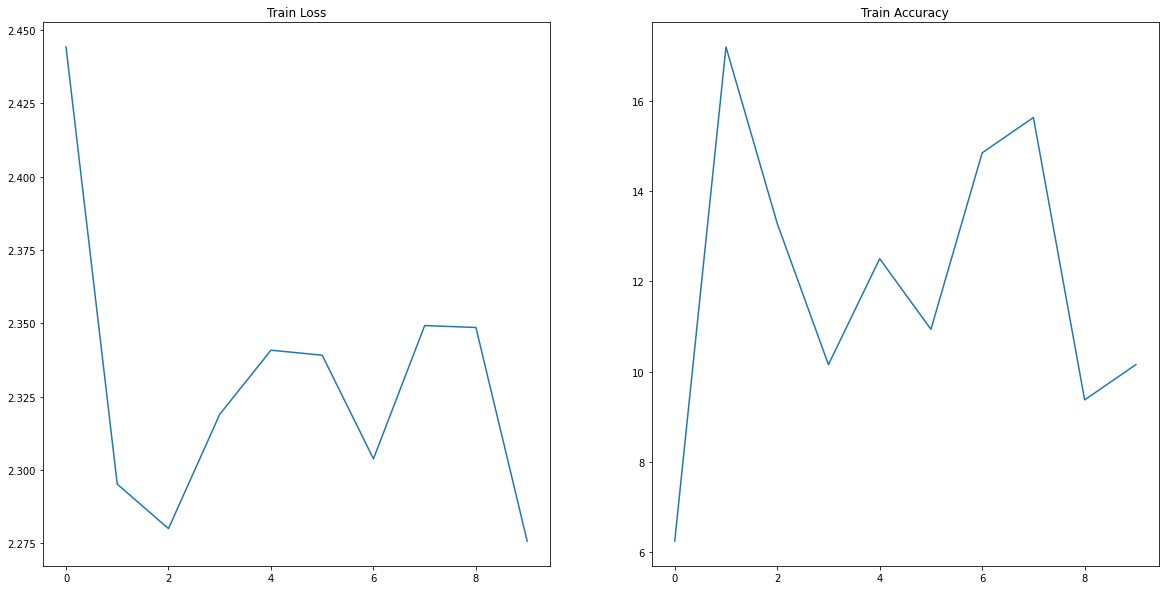

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(train_loss)
axs[0].set_title("Train Loss")

axs[1].plot(train_acc)
axs[1].set_title("Train Accuracy")

**Plot changes in Training and Test accuracy**

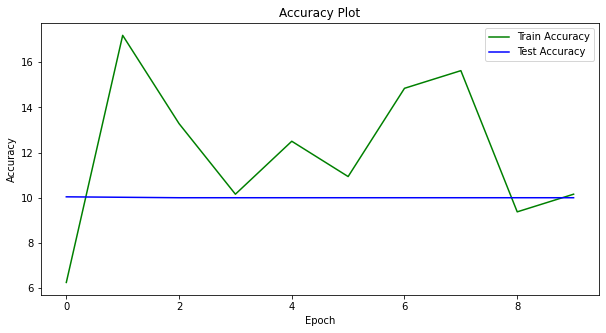

In [21]:
plot.plot_train_test_accuracy(train_acc,test_acc)

In [0]:
import shutil
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

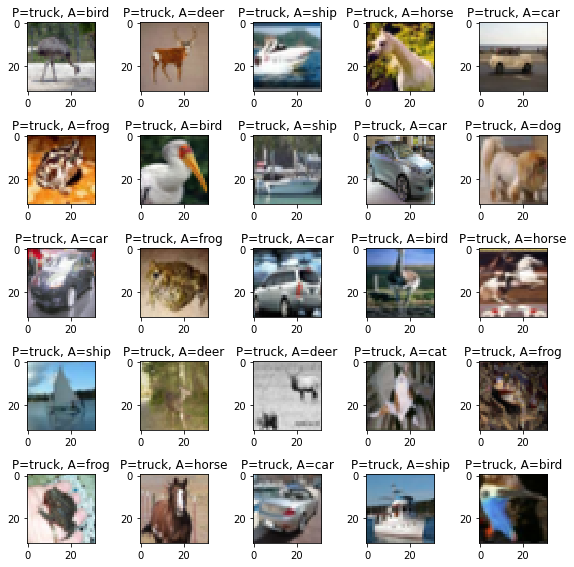

In [23]:
misclassified_images = evaluate.show_misclassified_images(model, device, testloader, classes)

**GradCam View of misclassified images(for all 4 layers)**


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


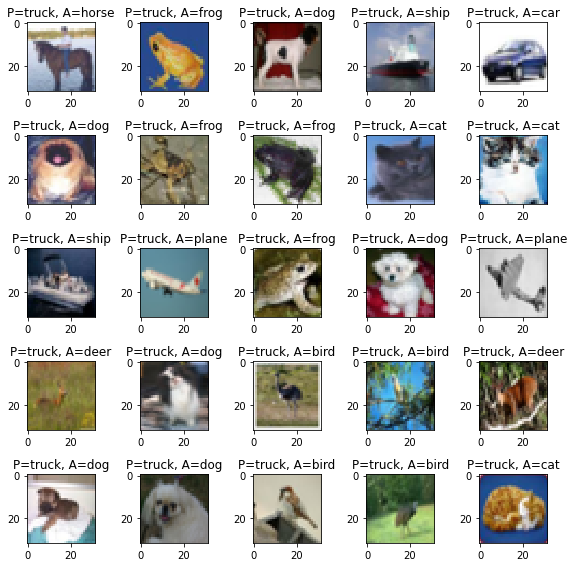

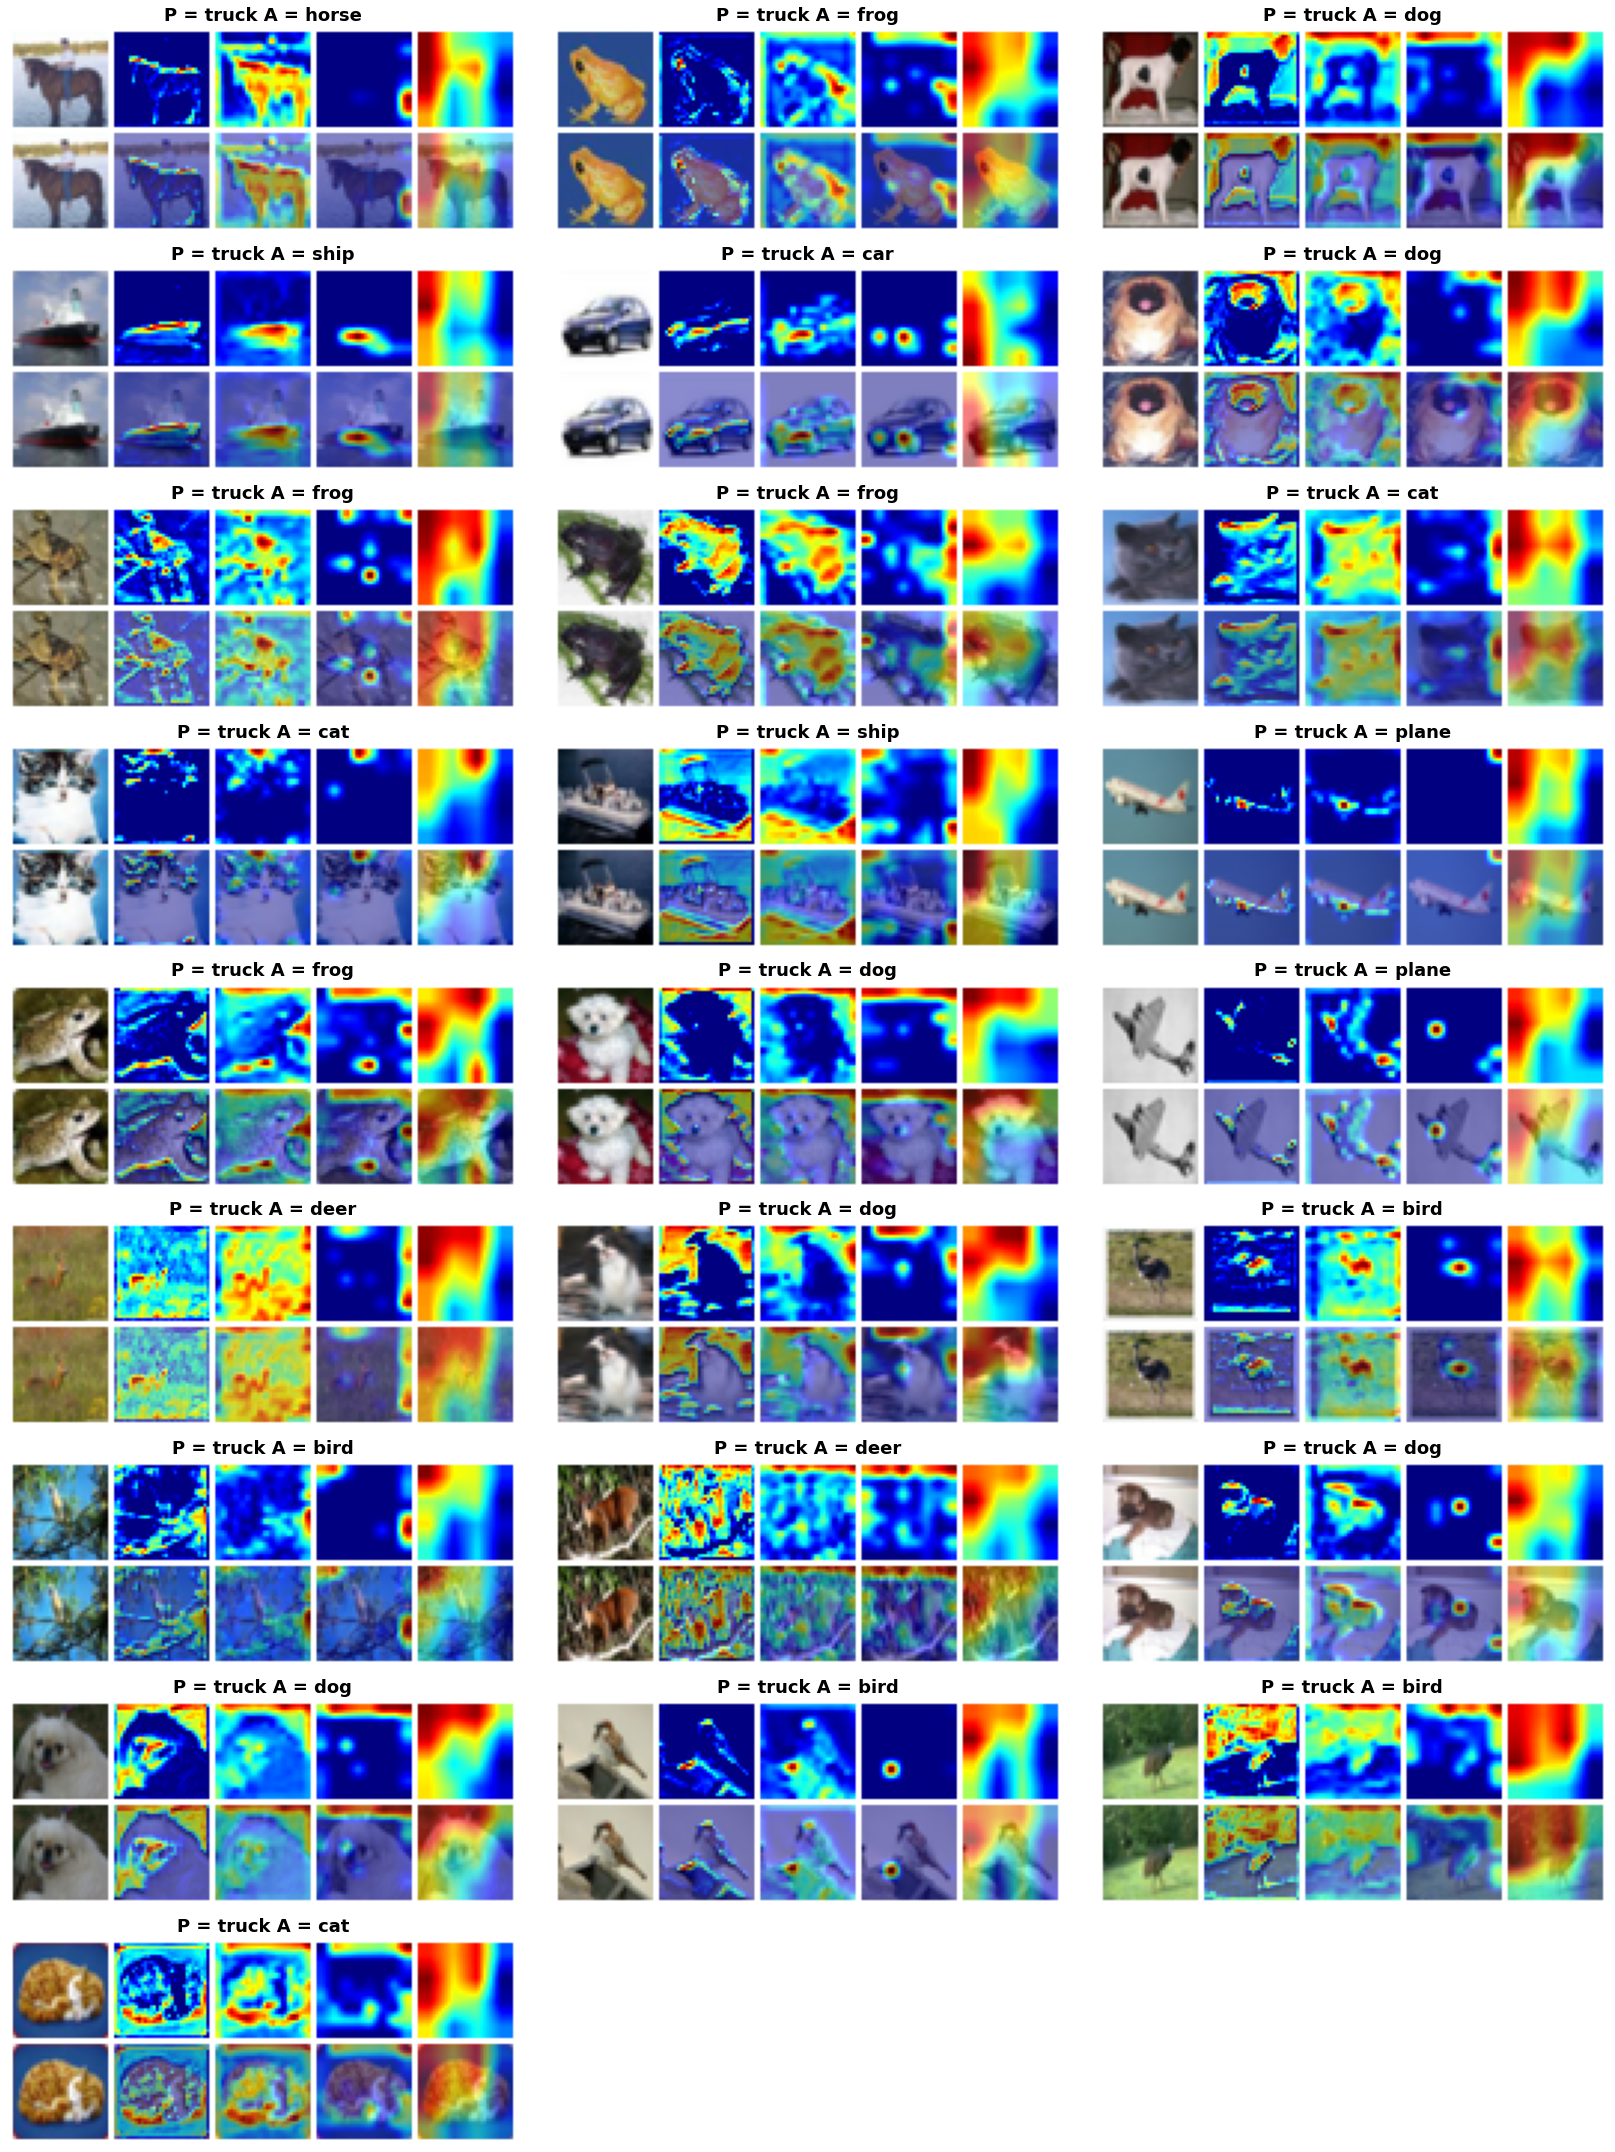

In [24]:
layers = [model.layer1,model.layer2,model.layer3,model.layer4]
miscalssified_images = evaluate.show_misclassified_images(model, device, testloader, classes)
gradcam.GradCamView(miscalssified_images,model,classes,layers)